## Innio Myplant Fleet Analysis


In [1]:
import arrow; print(arrow.now('Europe/Vienna').format('DD.MM.YYYY - HH:mm'))

05.02.2022 - 16:31


In [2]:
import dmyplant2
import json
import pandas as pd
import numpy as np
from tabulate import tabulate
from pprint import pprint as pp
import sys

In [3]:
dmyplant2.cred()            # get store credentials
mp = dmyplant2.MyPlant(0)   # connect to myplant and store Request Session for later requests

In [4]:
# fetch_installed_base(self,fields, properties, dataItems):
def get_installed_base():
    fields = ['serialNumber']

    properties =  [
        'Design Number','Engine Type','Engine Version','Engine Series','Engine ID',
        'Control System Type',
        'Country','IB Site Name','Commissioning Date','IB Unit Commissioning Date','Contract.Warranty Start Date', 'Contract.Warranty End Date','IB Status',
        'IB NOX', 'IB Frequency', 'IB Item Description Engine'
        ]

    dataItems = ['OperationalCondition','Module_Vers_HalIO','starts_oph_ratio','startup_counter',
    'shutdown_counter','Count_OpHour','Power_PowerNominal','Para_Speed_Nominal'
    ]
    fleet = mp.fetch_installed_base(fields, properties, dataItems, limit = None)
    fleet.to_pickle('Installed_base.pkl')
    return fleet

download_from_myplant = True
if download_from_myplant:
    fleet = get_installed_base()
else:
    try:
        fleet = pd.read_pickle('Installed_base.pkl')
    except:
        fleet = get_installed_base()

In [6]:
ffleet = fleet[
    #~fleet.OperationalCondition.isin(['Never Connected','Decommissioned','No Contact']) &
    #~fleet['Engine Type'].isnull() &
    fleet['Engine Type'].isin(['624'])
    #~dassets['Engine Version'].isin(['G01','G02','G09','G11','G111','G12','G375'])  &
    #fleet['Engine Series'].isin(['6'])
    ].copy().reset_index()

#ffleet.groupby( "Engine Type")['Count_OpHour'].describe().fillna(0).astype(int)
ffleet[['Engine Type','Count_OpHour','OperationalCondition','Commissioning Date']].agg({
    'Engine Type':['count'],
    'Count_OpHour':['count','min','max','median','mean'],
    'OperationalCondition': ['count']
})

,Engine Type,Count_OpHour,OperationalCondition
count,977.0,807.000000,977.0
min,NaN,0.000000,NaN
max,NaN,78441.000000,NaN
median,NaN,14299.000000,NaN
mean,NaN,18704.966543,NaN


In [7]:
ffleet[ffleet['Count_OpHour'] > 30000.0][['Commissioning Date','Count_OpHour','Engine Version','IB Site Name']].count()

Commissioning Date    179
Count_OpHour          179
Engine Version        178
IB Site Name          177
dtype: int64

In [8]:
fffleet = fleet[
    #~fleet.OperationalCondition.isin(['Never Connected','Decommissioned','No Contact']) &
    ~fleet.OperationalCondition.isin(['Decommissioned']) &
    ~fleet['Commissioning Date'].isin([np.NaN,' ']) &
    #~fleet['Engine Type'].isnull() &
    fleet['Engine Type'].isin(['624'])
    #~dassets['Engine Version'].isin(['G01','G02','G09','G11','G111','G12','G375'])  &
    #fleet['Engine Series'].isin(['6'])
    ].copy().reset_index()
sffleet=fffleet.sort_values(by = "Commissioning Date",ascending=True)

dset = ['Commissioning Date','Count_OpHour','Engine Version','IB Site Name']

In [9]:
sffleet[dset].head(15)

,Commissioning Date,Count_OpHour,Engine Version,IB Site Name
66,...,NaN,G01,TSTC Prototype P19
1,2008-09-19,49276.0,G01,HDM Power 1 (WP12 M10 EC2)
2,2008-09-19,35275.0,G01,HDM Power 2 (WP12 M11 EC2)
0,2009-04-03,40911.0,G11,C6 WEL
4,2009-11-17,37874.0,G01,Mooijman 2
10,2010-10-22,12258.0,G01,TLRS IVREA
46,2011-01-06,29783.0,H112,Cogevi Vinet
67,2011-01-16,28705.0,H112,VINET 2 JD PROD
41,2011-01-27,26885.0,G12,MAGUEUR KERIUNAN
3,2011-06-22,13722.0,G111,Hindustan National


In [10]:
sffleet[dset].tail(15)

,Commissioning Date,Count_OpHour,Engine Version,IB Site Name
641,2022-01-11,125.0,H12,Forsa Hartmoor
639,2022-01-11,126.0,H12,Forsa Hartmoor
638,2022-01-11,138.0,H12,Forsa Hartmoor
637,2022-01-11,146.0,H12,Forsa Hartmoor
634,2022-01-11,142.0,H12,Forsa Hartmoor
633,2022-01-11,134.0,H12,Forsa Hartmoor
650,2022-01-13,218.0,H01,Tep Sappi
682,2022-01-21,397.0,H01,BRASOV Nord 2
660,2022-01-21,249.0,K101,CQ National Grid
659,2022-01-21,374.0,K101,CQ National Grid


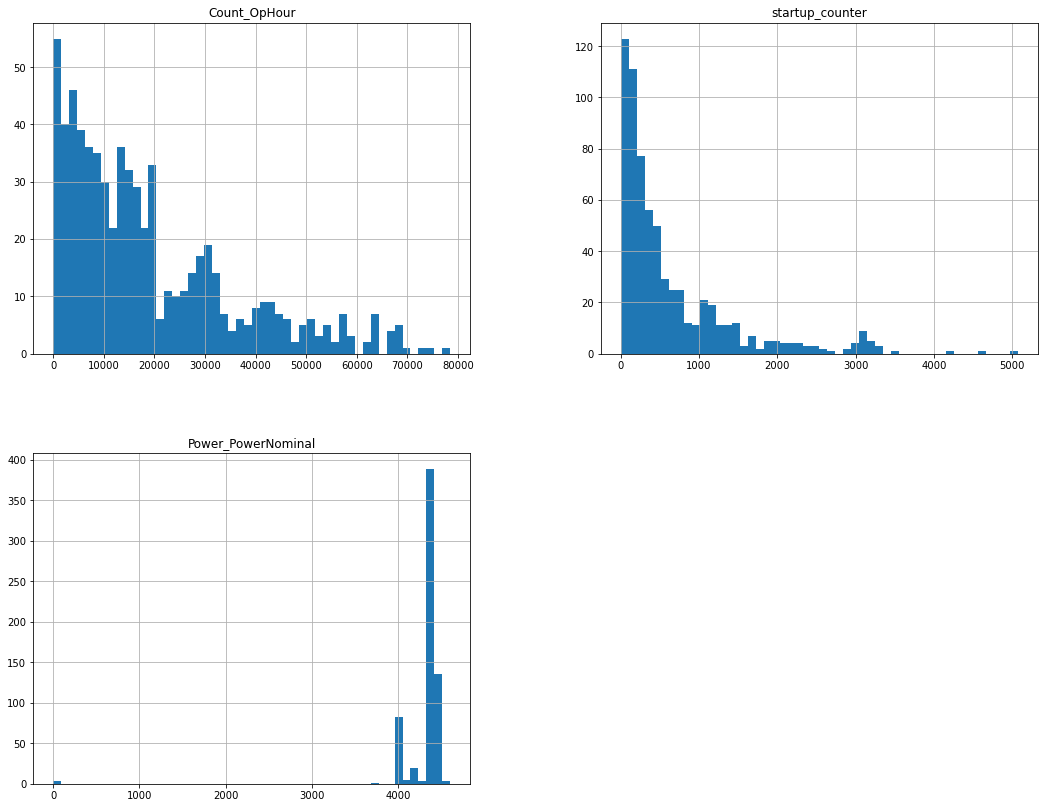

In [11]:
sffleet[sffleet['Count_OpHour'] > 0.0].hist(column=['Count_OpHour','startup_counter','Power_PowerNominal'],bins=50,figsize=(18,14));

In [12]:
rpfleet = sffleet[sffleet['IB Item Description Engine'].fillna('').str.contains('Repairs')].copy()
rpfleet

,index,Count_OpHour,OperationalCondition,shutdown_counter,startup_counter,id,Engine Version,Engine Type,Engine Series,Country,...,Engine ID,IB Unit Commissioning Date,IB NOX,IB Frequency,IB Item Description Engine,IB Site Name,IB Status,Contract.Warranty End Date,Contract.Warranty Start Date,Module_Vers_HalIO
64,10420,57388.0,Available,900.0,901.0,60505,G11,624,6,RO,...,M03,2010-11-30,500 mg/Nm3,50,Repairs.ENG.JMS.624,BRASOV Nord 1,Active,NaN,NaN,NaN
62,10418,58310.0,Running,1285.0,1284.0,60503,G11,624,6,RO,...,M02,2010-11-30,500 mg/Nm3,50,Repairs.ENG.JMS.624,BRASOV Nord 1,Active,NaN,NaN,NaN
645,26780,NaN,Never Connected,NaN,NaN,160087,G09,624,6,RU,...,M11,2012-04-28,500 mg/Nm3,50,Repairs.ENG.JGC.624,INTEKO,Temporarily Inactive,NaN,NaN,NaN
25,3420,43453.0,Available,3000.0,2994.0,8422,G01,624,6,NL,...,M01,2009-11-17,500,50,Repairs.ENG.JMS.624,Mooijman 1,Active,NaN,NaN,NaN
380,20846,53729.0,Running,1064.0,1064.0,122020,H01,624,6,NL,...,M02,2013-09-30,500 mg/Nm3,50,Repairs.ENG PREMIUM BLOCK.624,Looye Kwekers 2,Active,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,28456,13496.0,Available,89.0,90.0,171301,H01,624,6,NL,...,M16,2017-11-13,500 mg/Nm3,50,Repairs.ENG.JMS.624,Hoogweg 16,Active Docu incomplete,2022-11-08,2021-11-09,4.7.2.1.5
676,28454,50767.0,Running,110.0,111.0,171299,L11,624,6,NL,...,M01,2012-10-04,500 mg/Nm3,50,Repairs.ENG.PSB.624.L,Wisi 1,Active,2022-11-21,2021-12-02,NaN
680,28651,1529.0,Running,3.0,4.0,172706,H312,624,6,FR,...,M02,2018-10-30,250 mg/Nm3,50,Repairs.ENG.JMS.624,GAZ DE LACQ,Active Docu incomplete,2022-09-15,2021-09-16,4.4.0.1.10
677,28455,20680.0,Available,126.0,126.0,171300,L11,624,6,BE,...,M01,2018-11-16,500 mg/Nm3,50,Repairs.ENG.JMS.624,Den Horst 1,Active Docu incomplete,NaN,NaN,4.5.3.4.12


In [13]:
sffleet[dset].tail(15)

,Commissioning Date,Count_OpHour,Engine Version,IB Site Name
641,2022-01-11,125.0,H12,Forsa Hartmoor
639,2022-01-11,126.0,H12,Forsa Hartmoor
638,2022-01-11,138.0,H12,Forsa Hartmoor
637,2022-01-11,146.0,H12,Forsa Hartmoor
634,2022-01-11,142.0,H12,Forsa Hartmoor
633,2022-01-11,134.0,H12,Forsa Hartmoor
650,2022-01-13,218.0,H01,Tep Sappi
682,2022-01-21,397.0,H01,BRASOV Nord 2
660,2022-01-21,249.0,K101,CQ National Grid
659,2022-01-21,374.0,K101,CQ National Grid


In [14]:
# filter installed base
ffleet = fleet[
    fleet.OperationalCondition.isin(['Decommissioned']) &
    #~fleet['Engine Type'].isnull() &
    fleet['Engine Type'].isin(['624']) &   
    #~fleet['Engine Version'].isin(['G01','G02','G09','G11','G111','G12','G375'])  &
    fleet['Engine Series'].isin(['6'])
    ].copy().reset_index()

ffleet.groupby( "Engine Type")[['Count_OpHour']].describe()

Count_OpHour                                                     \
                   count          mean           std  min      25%      50%   
Engine Type                                                                   
624                106.0  21539.103774  16519.431618  0.0  7601.25  19760.5   

                                
                  75%      max  
Engine Type                     
624          32442.25  67442.0

In [15]:
dfleet=fleet.groupby('Engine Type').head(1000000)
#dfleet.pivot_table(index='Engine Version', columns='Engine Type', values='Count_OpHour', aggfunc=['count','mean','max','sum'], margins=True).round(0).fillna('')
dfleet.pivot_table(index='Engine Series', columns='Engine Type', values='serialNumber', aggfunc=['count'], margins=False).fillna('')
#round(0).fillna(0).astype(int)

count                                                   ...  \
Engine Type           320  416  612  620  ...   106   156  206    208  ...   
Engine Series                                                          ...   
               109.0                                                   ...   
 3                    1.0                                              ...   
 4                         1.0                                         ...   
 6                              1.0  1.0                               ...   
...                                       5.0                          ...   
1                                              19.0  67.0              ...   
2                                                          4.0  859.0  ...   
3                1.0                                                   ...   
4                                                                      ...   
6                                                                      ...   
9                                                                      ...   
J                                                                      ...   
MSY                                                                    ...   
T                                                                      ...   

                                                                             \
Engine Type       420  424     612     616     620    624   920 JW 160  MSY   
Engine Series                                                                 
                                                                              
 3                                                                            
 4                                                                            
 6                                                                            
...                                                                           
1                                                                             
2                                                                             
3                                                                             
4              4466.0  5.0                                                    
6                           1209.0  1627.0  3343.0  977.0                     
9                                                          56.0               
J                                                                  1.0        
MSY                                                                     2.0   
T                                                                             

                           
Engine Type   TCR12-41526  
Engine Series              
                           
 3                         
 4                         
 6                         
...                        
1                          
2                          
3                          
4                          
6                          
9                          
J                          
MSY                        
T                     1.0  

[14 rows x 28 columns]